Importing libraries

In [2]:
#Setup oneDNN in Devcloud:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'


##To configure oneDNN to use GPU acceleration
os.environ['DNNL_ENGINE_LIMIT_CPU_CAPABILITIES'] = '0'
os.environ['DNNL_VERBOSE'] = '1'
os.environ['SYCL_DEVICE_FILTER'] = 'opencl:gpu'

import tensorflow as tf
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

Dataset Path

In [8]:
BASE_PATH = 'coco2017'

Sampling a subset of 70,000 image-caption pairs

In [9]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,coco2017/train2017/000000056486.jpg,A pizza sitting on top of a pan topped with ch...
1,coco2017/train2017/000000014709.jpg,A baseball player holding a catchers mitt in t...
2,coco2017/train2017/000000414148.jpg,A old picture of workers building the railroad.
3,coco2017/train2017/000000419879.jpg,A stoplight at the intersection with Broadway ...
4,coco2017/train2017/000000302312.jpg,a guy that is skating on a concrete ramp


**Preprocessing**

* converting to lowercase
* removing punctuation
* adding start and end tokens to prepare it

In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

* Storing preprocessed captions to main caption

In [5]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,../input/coco-2017-dataset/coco2017/train2017/...,[start] a couple of sheep standing next to a t...
1,../input/coco-2017-dataset/coco2017/train2017/...,[start] a very large semi truck on a wide road...
2,../input/coco-2017-dataset/coco2017/train2017/...,[start] a man is in a black and white public r...
3,../input/coco-2017-dataset/coco2017/train2017/...,[start] a couple of electronics devices stacke...
4,../input/coco-2017-dataset/coco2017/train2017/...,[start] small bus turning on city street after...


* Displaying images

[start] a little girl holds an older persons hand while walking on the sidewalk [end]



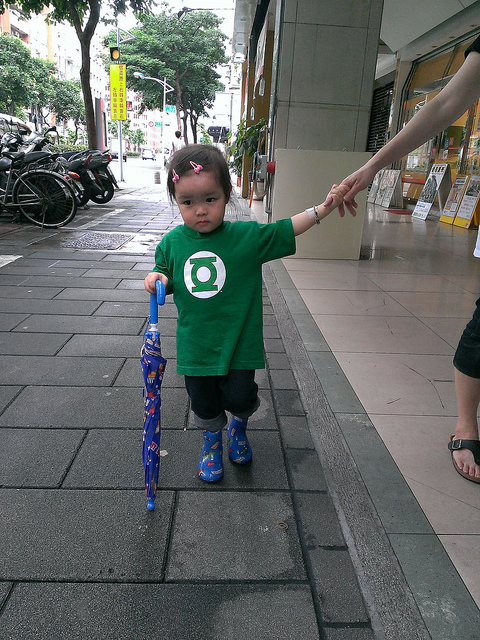

In [6]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

* Hyperparameters

In [7]:
MAX_LENGTH = 40         #Maximum caption length (words)
VOCABULARY_SIZE = 15000 #Size of word vocabulary
BATCH_SIZE = 64         #Number of samples per batch
BUFFER_SIZE = 1000      #Size of shuffle buffer
EMBEDDING_DIM = 512     #Word embedding dimension
UNITS = 512             #RNN layer units
EPOCHS = 50              #Number of training epochs

* creating a tokenizer
* sets parameters for vocabulary size and sequence length
* adapts the tokenizer to the provided caption data

In [8]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [9]:
tokenizer.vocabulary_size()

11847

*  saving the tokenizer vocabulary into 'vocab_coco.file'

In [10]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

* creating two components (word2idx and idx2word) for mapping words to integer indices and vice versa.

In [11]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

* processeing image-caption data
* organizing into training and validation sets
* creating lists of image names and captions for each set.

In [12]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [13]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(55970, 55970, 14030, 14030)

* resizing image
* preprocessing image
* tokenizing the caption

In [14]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

* Combine image-caption pairs
* Preprocess, shuffle, batch
* Prepare for training

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Image Augmentation

In [16]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

* InceptionV3-based Encoder
* Reshapes output tensor
* Extracts image features

In [17]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

* single layer encoder

In [18]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

* Custom Embeddings layer for Transformer
* Token and Position embeddings combined
* Vocabulary size and Embedding dimension
* Positional information for Transformer models
* Maps tokens to dense vectors

In [19]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

* Custom Transformer Decoder Layer
* Self-attention and Cross-attention mechanisms
* Layer normalization and Residual connections
* Feedforward neural network (FFN) processing
* Causal attention mask (Avoids information Leakage)

In [20]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

* Image Captioning Model
* Loss and accuracy calculations
* Training and testing steps
* Metrics tracking

In [21]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

* Image Captioning Model creation

In [22]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 [==============================] - 1s 0us/step


* Sparse categorical cross-entropy loss
* Early stopping callback
* Adam optimizer

In [23]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

* Applying model

In [24]:
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/50
875/875 [==============================] - 677s 740ms/step - loss: 4.2157 - acc: 0.2535 - val_loss: 3.5856 - val_acc: 0.3672
Epoch 2/50
875/875 [==============================] - 536s 606ms/step - loss: 3.3628 - acc: 0.3820 - val_loss: 3.3060 - val_acc: 0.4010
Epoch 3/50
875/875 [==============================] - 502s 568ms/step - loss: 3.1191 - acc: 0.4080 - val_loss: 3.2025 - val_acc: 0.4113
Epoch 4/50
875/875 [==============================] - 513s 579ms/step - loss: 2.9739 - acc: 0.4214 - val_loss: 3.1545 - val_acc: 0.4170
Epoch 5/50
875/875 [==============================] - 528s 596ms/step - loss: 2.8699 - acc: 0.4317 - val_loss: 3.1354 - val_acc: 0.4200
Epoch 6/50
875/875 [==============================] - 503s 568ms/step - loss: 2.7840 - acc: 0.4389 - val_loss: 3.1422 - val_acc: 0.4215
Epoch 7/50
875/875 [==============================] - 517s 584ms/step - loss: 2.7101 - acc: 0.4463 - val_loss: 3.1397 - val_acc: 0.4221
Epoch 8/50
875/875 [============================

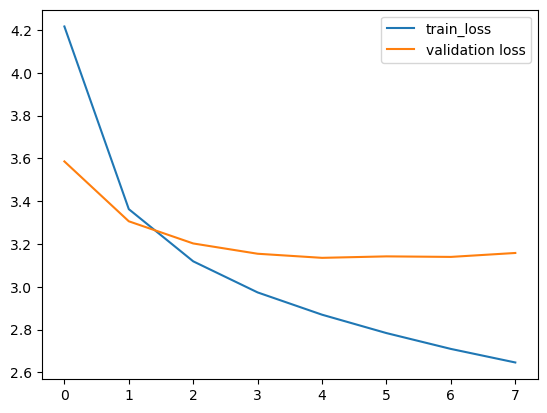

In [25]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

* Image loading and caption generating function

In [26]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

* Sample caption below

Predicted Caption: a man riding a surfboard on a wave



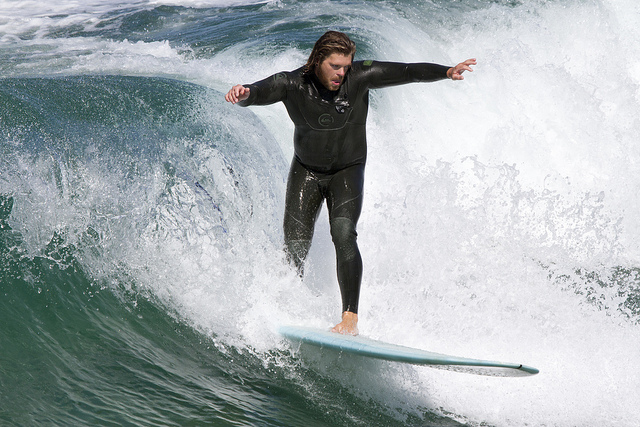

In [29]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)